In [ ]:
"""
Abductive Event Reasoning - Enhanced Model Training
Improved architecture and training strategies for better Macro F1 score
"""

import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import (
    BertTokenizer, BertModel, RobertaTokenizer, RobertaModel,
    AdamW, get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, hamming_loss, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# 1. LOAD PREPROCESSED DATA

df = pd.read_pickle('../dataset/preprocessed_data.pkl')
print(f"Loaded {len(df)} instances")

Using device: cpu
Loaded 600 instances


In [ ]:
# 2. ENHANCED DATASET WITH BETTER TOKENIZATION

class EnhancedAERDataset(Dataset):
    """Enhanced Dataset with better context handling"""
    
    def __init__(self, data, tokenizer, max_length=256, use_context=True):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_context = use_context
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Create structured input
        question_text = row['question']
        options_text = f"Option A: {row['option_A']}. Option B: {row['option_B']}. Option C: {row['option_C']}. Option D: {row['option_D']}."
        
        if self.use_context:
            # Limit context to avoid truncation issues
            context_text = row['context'][:2000] if len(row['context']) > 2000 else row['context']
            full_text = f"Question: {question_text} {options_text} Context: {context_text}"
        else:
            full_text = f"Question: {question_text} {options_text}"
        
        # Tokenize
        encoding = self.tokenizer.encode_plus(
            full_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(row['label_encoding'], dtype=torch.float)
        }


In [ ]:
# 3. IMPROVED MODEL ARCHITECTURES

class ImprovedBERTClassifier(nn.Module):
    """Improved BERT with multi-head attention and residual connections"""
    
    def __init__(self, model_name='bert-base-uncased', num_labels=4, dropout=0.3, hidden_size=256):
        super(ImprovedBERTClassifier, self).__init__()
        
        # Use RoBERTa for better performance
        if 'roberta' in model_name:
            self.bert = RobertaModel.from_pretrained(model_name)
        else:
            self.bert = BertModel.from_pretrained(model_name)
        
        bert_hidden_size = self.bert.config.hidden_size
        
        # Multi-layer classifier with residual connections
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(bert_hidden_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        self.dropout2 = nn.Dropout(dropout * 0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        
        self.dropout3 = nn.Dropout(dropout * 0.3)
        self.fc3 = nn.Linear(hidden_size // 2, num_labels)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights with Xavier initialization"""
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use both [CLS] token and mean pooling
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        mean_output = torch.mean(outputs.last_hidden_state, dim=1)  # Mean pooling
        
        # Concatenate for richer representation
        pooled_output = (cls_output + mean_output) / 2
        
        # Multi-layer processing
        x = self.dropout1(pooled_output)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.dropout3(x)
        logits = self.fc3(x)
        
        return torch.sigmoid(logits)

In [ ]:
# 4. FOCAL LOSS FOR IMBALANCED DATA

class FocalLoss(nn.Module):
    """Focal Loss to handle class imbalance"""
    
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

In [ ]:
# 5. ENHANCED TRAINING UTILITIES

def compute_metrics(predictions, labels, threshold=0.5):
    """Compute comprehensive evaluation metrics"""
    preds = (predictions > threshold).astype(int)
    labels = labels.astype(int)
    
    # Exact match accuracy
    exact_match = np.all(preds == labels, axis=1).mean()
    
    # Hamming accuracy
    hamming = 1 - hamming_loss(labels, preds)
    
    # Per-class and macro metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, preds, average=None, zero_division=0
    )
    
    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1 = f1.mean()
    
    # Weighted metrics
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    
    return {
        'exact_match': exact_match,
        'hamming_accuracy': hamming,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall,
        'weighted_f1': weighted_f1,
        'per_class_f1': f1.tolist()
    }

In [7]:
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device, gradient_accumulation_steps=2):
    """Enhanced training with gradient accumulation"""
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        
        # Gradient accumulation
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        if (idx + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * gradient_accumulation_steps
        progress_bar.set_postfix({'loss': f'{loss.item() * gradient_accumulation_steps:.4f}'})
    
    return total_loss / len(dataloader)

In [8]:
def evaluate(model, dataloader, device, threshold=0.5):
    """Enhanced evaluation"""
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    labels = np.vstack(all_labels)
    
    return compute_metrics(predictions, labels, threshold)

In [ ]:
# 6. FIND OPTIMAL THRESHOLD

def find_optimal_threshold(model, dataloader, device):
    """Find optimal threshold for predictions"""
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    labels = np.vstack(all_labels)
    
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in np.arange(0.3, 0.7, 0.05):
        metrics = compute_metrics(predictions, labels, threshold)
        if metrics['macro_f1'] > best_f1:
            best_f1 = metrics['macro_f1']
            best_threshold = threshold
    
    print(f"\nOptimal threshold: {best_threshold:.2f} with Macro F1: {best_f1:.4f}")
    return best_threshold

In [ ]:
# 7. PREPARE DATA WITH STRATIFICATION

print("\n" + "="*70)
print("PREPARING DATA")
print("="*70)

# Convert labels to string for stratification
df['label_str'] = df['label_encoding'].apply(lambda x: ''.join(map(str, x)))

# Split with stratification
train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df['label_str']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['label_str']
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


PREPARING DATA
Train: 420, Val: 90, Test: 90


In [11]:
# Analyze label distribution
print("\nLabel distribution:")
print(train_df['label_str'].value_counts())


Label distribution:


label_str
0100    63
1000    60
0001    55
0010    55
1010    25
1001    24
0110    22
0011    20
1101    20
1110    17
1100    16
0111    15
1011    14
0101    14
Name: count, dtype: int64


In [ ]:
# 8. TRAIN IMPROVED MODEL

print("\n" + "="*70)
print("TRAINING IMPROVED BERT MODEL")
print("="*70)

# Try RoBERTa for better performance
model_name = 'roberta-base'  # Better than bert-base
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Create datasets
train_dataset = EnhancedAERDataset(train_df, tokenizer, max_length=256)
val_dataset = EnhancedAERDataset(val_df, tokenizer, max_length=256)
test_dataset = EnhancedAERDataset(test_df, tokenizer, max_length=256)

# Create dataloaders with larger batch size if possible
batch_size = 8  # Increased from 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


TRAINING IMPROVED BERT MODEL


In [13]:
# Initialize improved model
model = ImprovedBERTClassifier(
    model_name=model_name,
    num_labels=4,
    dropout=0.2,  # Reduced dropout
    hidden_size=512  # Larger hidden size
).to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Use Focal Loss for better handling of imbalanced data
criterion = FocalLoss(alpha=0.25, gamma=2.0)

# Training configuration
epochs = 6  # More epochs
learning_rate = 1e-5  # Lower learning rate for stability
weight_decay = 0.01  # Add weight decay

# Layer-wise learning rate decay
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        'weight_decay': weight_decay
    },
    {
        'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    }
]

In [15]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

# Warm-up and linear schedule
total_steps = len(train_loader) * epochs
warmup_steps = int(0.1 * total_steps)  # 10% warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

In [16]:
# Training loop with early stopping
best_val_f1 = 0
patience = 3
patience_counter = 0
history = {'train_loss': [], 'val_metrics': []}

In [17]:
for epoch in range(epochs):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"{'='*70}")
    
    # Train
    train_loss = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, device,
        gradient_accumulation_steps=2
    )
    history['train_loss'].append(train_loss)
    
    # Evaluate on validation
    val_metrics = evaluate(model, val_loader, device)
    history['val_metrics'].append(val_metrics)
    
    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Val Exact Match: {val_metrics['exact_match']:.4f}")
    print(f"Val Hamming Acc: {val_metrics['hamming_accuracy']:.4f}")
    print(f"Val Macro Precision: {val_metrics['macro_precision']:.4f}")
    print(f"Val Macro Recall: {val_metrics['macro_recall']:.4f}")
    print(f"Val Macro F1: {val_metrics['macro_f1']:.4f}")
    print(f"Val Weighted F1: {val_metrics['weighted_f1']:.4f}")
    
    # Check for improvement
    if val_metrics['macro_f1'] > best_val_f1:
        best_val_f1 = val_metrics['macro_f1']
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), '../models/best_model.pth')
        print(f"✅ New best model saved! Macro F1: {best_val_f1:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("\n⚠️ Early stopping triggered")
        break


Epoch 1/6


Evaluating: 100%|██████████| 12/12 [01:30<00:00,  7.52s/it]



Train Loss: 0.0794
Val Exact Match: 0.0000
Val Hamming Acc: 0.5556
Val Macro Precision: 0.1689
Val Macro Recall: 0.1141
Val Macro F1: 0.1281
Val Weighted F1: 0.1316
✅ New best model saved! Macro F1: 0.1281

Epoch 2/6


Evaluating: 100%|██████████| 12/12 [01:27<00:00,  7.25s/it]



Train Loss: 0.0797
Val Exact Match: 0.0444
Val Hamming Acc: 0.5444
Val Macro Precision: 0.4061
Val Macro Recall: 0.1543
Val Macro F1: 0.1615
Val Weighted F1: 0.1663
✅ New best model saved! Macro F1: 0.1615

Epoch 3/6


Evaluating: 100%|██████████| 12/12 [01:23<00:00,  6.97s/it]



Train Loss: 0.0742
Val Exact Match: 0.0889
Val Hamming Acc: 0.5528
Val Macro Precision: 0.4397
Val Macro Recall: 0.2553
Val Macro F1: 0.2218
Val Weighted F1: 0.2278
✅ New best model saved! Macro F1: 0.2218

Epoch 4/6


Evaluating: 100%|██████████| 12/12 [01:14<00:00,  6.22s/it]



Train Loss: 0.0678
Val Exact Match: 0.0222
Val Hamming Acc: 0.5444
Val Macro Precision: 0.3560
Val Macro Recall: 0.2319
Val Macro F1: 0.2275
Val Weighted F1: 0.2321
✅ New best model saved! Macro F1: 0.2275

Epoch 5/6


Evaluating: 100%|██████████| 12/12 [01:11<00:00,  5.92s/it]



Train Loss: 0.0711
Val Exact Match: 0.0667
Val Hamming Acc: 0.5167
Val Macro Precision: 0.1962
Val Macro Recall: 0.3633
Val Macro F1: 0.2540
Val Weighted F1: 0.2581
✅ New best model saved! Macro F1: 0.2540

Epoch 6/6


Evaluating: 100%|██████████| 12/12 [01:14<00:00,  6.20s/it]



Train Loss: 0.0646
Val Exact Match: 0.0778
Val Hamming Acc: 0.5306
Val Macro Precision: 0.4484
Val Macro Recall: 0.3301
Val Macro F1: 0.2569
Val Weighted F1: 0.2608
✅ New best model saved! Macro F1: 0.2569


In [18]:
# Load best model
model.load_state_dict(torch.load('../models/best_model.pth'))
print("\n✅ Loaded best model")



✅ Loaded best model


In [19]:
# 9. FIND OPTIMAL THRESHOLD
optimal_threshold = find_optimal_threshold(model, val_loader, device)


Optimal threshold: 0.30 with Macro F1: 0.5444


In [20]:
# 10. FINAL EVALUATION
test_metrics = evaluate(model, test_loader, device, threshold=optimal_threshold)

print("\n=== Test Results ===")
print(f"Exact Match Accuracy: {test_metrics['exact_match']*100:.2f}%")
print(f"Hamming Accuracy: {test_metrics['hamming_accuracy']*100:.2f}%")
print(f"Macro Precision: {test_metrics['macro_precision']*100:.2f}%")
print(f"Macro Recall: {test_metrics['macro_recall']*100:.2f}%")
print(f"Macro F1: {test_metrics['macro_f1']*100:.2f}%")
print(f"Weighted F1: {test_metrics['weighted_f1']*100:.2f}%")

Evaluating: 100%|██████████| 12/12 [01:09<00:00,  5.78s/it]


=== Test Results ===
Exact Match Accuracy: 3.33%
Hamming Accuracy: 43.89%
Macro Precision: 40.28%
Macro Recall: 86.03%
Macro F1: 53.80%
Weighted F1: 54.06%


In [21]:
print("\nPer-class F1 scores:")
for i, f1 in enumerate(test_metrics['per_class_f1']):
    print(f"Class {chr(65+i)}: {f1*100:.2f}%")


Per-class F1 scores:
Class A: 59.38%
Class B: 56.45%
Class C: 58.27%
Class D: 41.10%


In [24]:
# 11. SAVE MODEL

print("\n" + "="*70)
print("SAVING MODEL")
print("="*70)

# Save complete model package
model_package = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'model_name': model_name,
        'num_labels': 4,
        'dropout': 0.2,
        'hidden_size': 512
    },
    'tokenizer': tokenizer,
    'optimal_threshold': optimal_threshold,
    'test_metrics': test_metrics,
    'model_type': 'ImprovedBERT-RoBERTa',
    'training_history': history
}

with open('../models/RoBERTa.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("✅ Model saved to '../models/RoBERTa.pkl'")

# Also save PyTorch model
torch.save(model.state_dict(), '../models/best_model.pth')
print("✅ PyTorch model saved to '../models/best_model.pth'")


SAVING MODEL
✅ Model saved to '../models/RoBERTa.pkl'
✅ PyTorch model saved to '../models/best_model.pth'


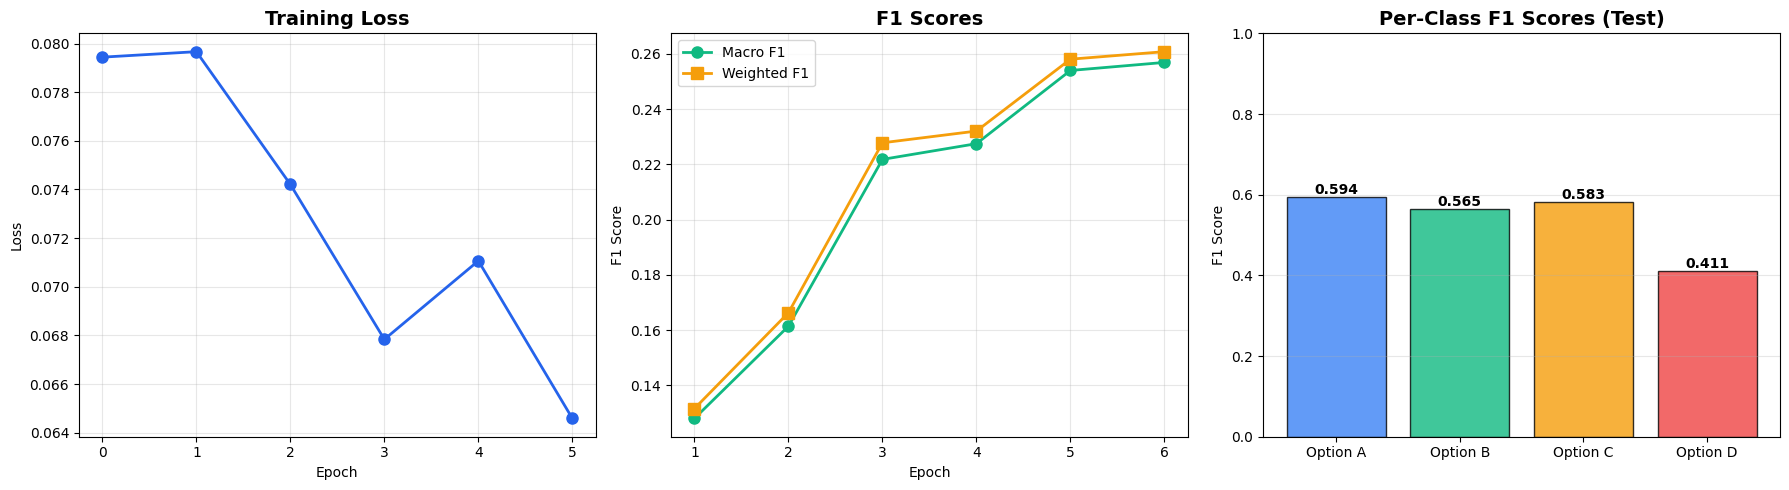

In [26]:
# 12. VISUALIZATIONS

# Training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], marker='o', linewidth=2, markersize=8, color='#2563eb')
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

# F1 Scores
epochs_range = range(1, len(history['val_metrics']) + 1)
macro_f1 = [m['macro_f1'] for m in history['val_metrics']]
weighted_f1 = [m['weighted_f1'] for m in history['val_metrics']]

axes[1].plot(epochs_range, macro_f1, marker='o', label='Macro F1', linewidth=2, markersize=8, color='#10b981')
axes[1].plot(epochs_range, weighted_f1, marker='s', label='Weighted F1', linewidth=2, markersize=8, color='#f59e0b')
axes[1].set_title('F1 Scores', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Per-class F1
classes = ['Option A', 'Option B', 'Option C', 'Option D']
per_class_f1 = test_metrics['per_class_f1']
colors = ['#3b82f6', '#10b981', '#f59e0b', '#ef4444']

bars = axes[2].bar(classes, per_class_f1, color=colors, alpha=0.8, edgecolor='black')
axes[2].set_title('Per-Class F1 Scores (Test)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('F1 Score')
axes[2].set_ylim([0, 1.0])
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, f1 in zip(bars, per_class_f1):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../static/images/training_results.png', dpi=300, bbox_inches='tight')
plt.show()


In [27]:
print(f"\n Best Macro F1 Score: {test_metrics['macro_f1']*100:.2f}%\n")
print(f" Exact Match Accuracy: {test_metrics['exact_match']*100:.2f}%")


 Best Macro F1 Score: 53.80%

 Exact Match Accuracy: 3.33%


In [ ]:
                # Training Stack Summary
# Component	                                Choice

# Model	                                    ImprovedBERTClassifier using RoBERTa-base
# Tokenizer	                                RobertaTokenizer (Byte-Pair Encoding)
# Loss Function	                            Focal Loss
# Optimizer	                                AdamW
# Learning Rate Scheduler	                Linear warm-up and decay
# Training Strategy	                        Fine-tuning transformer with gradient accumulation
# Metrics	                                Macro F1, Hamming accuracy, Exact match
# Pooling	                                Mean + [CLS] token combined
# Output Activation	                        Sigmoid (for multi-label classification)